## Лабораторная работа №1
1. С помощью приложенного файла сгенерировать временной ряд. Отрисовать ряд. Провести классические статистические тесты. Провести разделение ряда на компоненты.
2. Отрисовать автокорреляционные функции. Выбрать статистический метод моделирования. Привести текстовое обоснование выбора. Смоделировать ряд, сделав предсказание на разумный период. Провести анализ метрик. Изобразить график модели с предсказанием с учетом возможных ошибок.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (14,5)
plt.style.use("seaborn-v0_8")


In [ ]:
def generate_time_series(n_points=1000, has_trend=True, has_seasonality=True, seed=42):
    np.random.seed(seed)
    start_date = datetime(2020, 1, 1)
    dates = pd.date_range(start=start_date, periods=n_points, freq='D')
    noise = np.random.normal(0, 5, n_points)

    trend_component = np.zeros(n_points)
    seasonal_component = np.zeros(n_points)

    if has_trend:
        slope = 0.02
        intercept = 80
        trend_component = slope * np.arange(n_points) + intercept

    if has_seasonality:
        seasonal_component += 20 * np.sin(2*np.pi*np.arange(n_points)/365 + 0.5)
        seasonal_component += 8 * np.sin(2*np.pi*np.arange(n_points)/30 + 1.0)

    values = noise + trend_component + seasonal_component
    return pd.Series(values, index=dates)


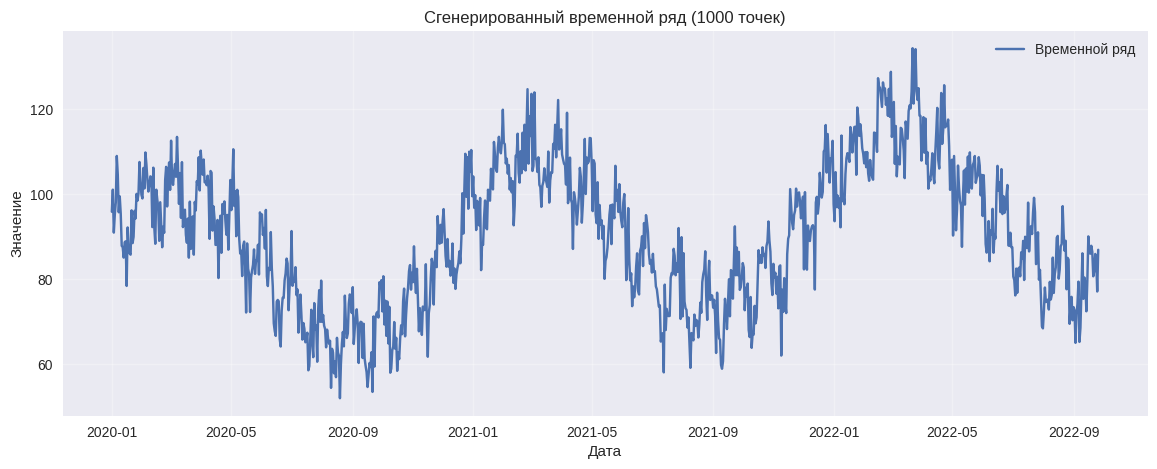

In [ ]:
series = generate_time_series(n_points=1000, seed=2025)

plt.figure(figsize=(14,5))
plt.plot(series, label='Временной ряд')
plt.title('Сгенерированный временной ряд (1000 точек)')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.grid(alpha=0.3)
plt.legend()
plt.show()


In [ ]:
def adf_test(x):
    res = adfuller(x, autolag='AIC')
    return {'ADF statistic': res[0], 'p-value': res[1]}

def kpss_test(x, nlags="auto"):
    res = kpss(x, nlags=nlags, regression='c')
    return {'KPSS statistic': res[0], 'p-value': res[1]}

adf_res = adf_test(series)
kpss_res = kpss_test(series)
lb_res = acorr_ljungbox(series, lags=[10,20,30], return_df=True)

print("ADF:", adf_res)
print("KPSS:", kpss_res)
lb_res


ADF: {'ADF statistic': np.float64(-0.8785401709836298), 'p-value': np.float64(0.7949572825496554)}
KPSS: {'KPSS statistic': np.float64(0.5173731576474638), 'p-value': np.float64(0.03775379332264328)}


,lb_stat,lb_pvalue
10,7019.585169,0.0
20,11691.161230,0.0
30,17951.648842,0.0


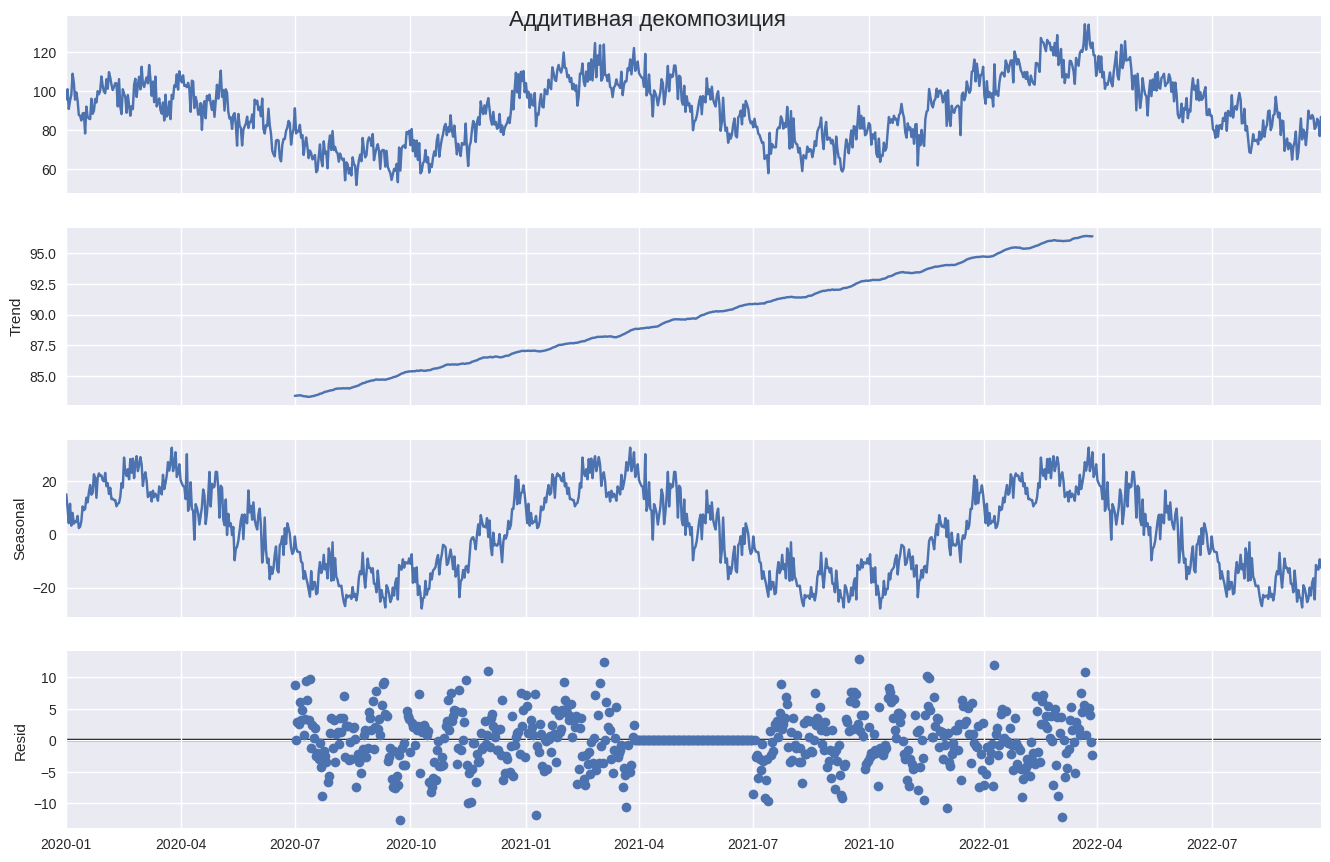

In [ ]:
decomp = seasonal_decompose(series, model='additive', period=365)
fig = decomp.plot()
fig.set_size_inches(14,9)
plt.suptitle("Аддитивная декомпозиция", fontsize=16)
plt.show()


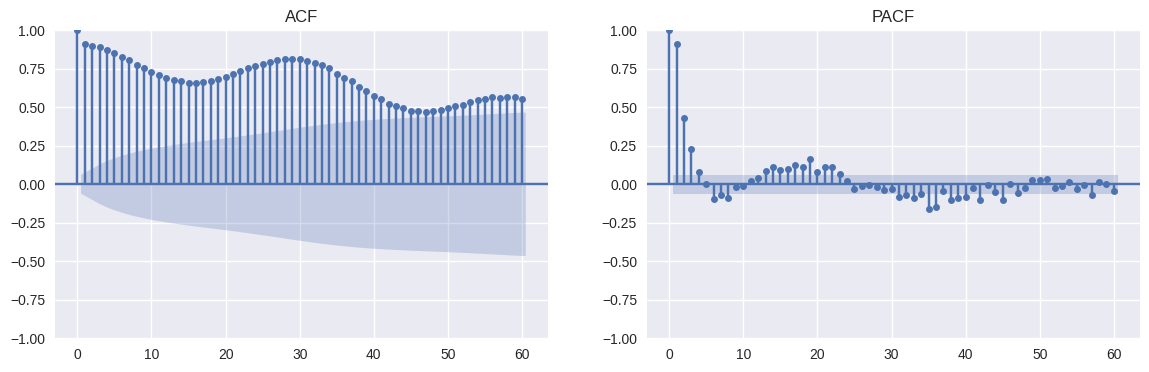

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14,4))
plot_acf(series, lags=60, ax=axes[0])
plot_pacf(series, lags=60, ax=axes[1], method='ywm')
axes[0].set_title('ACF')
axes[1].set_title('PACF')
plt.show()


In [ ]:
h = 90
train = series[:-h]
test = series[-h:]

series_diff = train.diff().dropna()

print("ADF (diff):", adf_test(series_diff))
print("KPSS (diff):", kpss_test(series_diff))


ADF (diff): {'ADF statistic': np.float64(-13.90415647625428), 'p-value': np.float64(5.66302261044027e-26)}
KPSS (diff): {'KPSS statistic': np.float64(0.05374354433927704), 'p-value': np.float64(0.1)}


In [ ]:
best_aic = np.inf
best_order = None
best_model = None

p_range = range(0,4)
q_range = range(0,4)
d = 1

for p in p_range:
    for q in q_range:
        try:
            model = SARIMAX(train, order=(p,d,q), seasonal_order=(0,0,0,0),
                            enforce_stationarity=False, enforce_invertibility=False)
            res = model.fit(disp=False)
            if res.aic < best_aic:
                best_aic = res.aic
                best_order = (p,d,q)
                best_model = res
        except:
            pass

print("Лучшая модель ARIMA:", best_order, "AIC=", best_aic)


Лучшая модель ARIMA: (1, 1, 3) AIC= 5791.400228753462


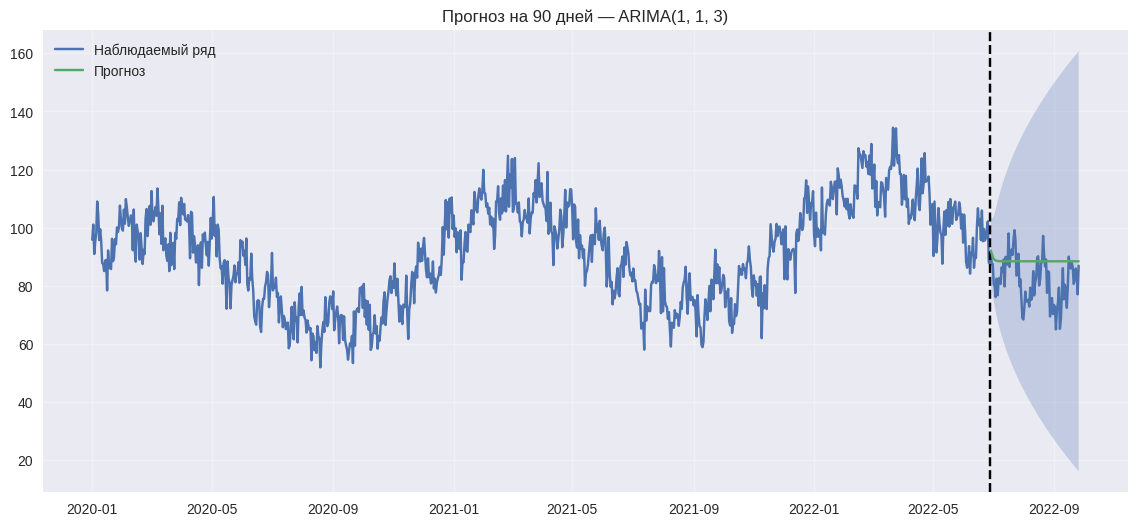

In [ ]:
forecast = best_model.get_forecast(steps=h)
pred_mean = forecast.predicted_mean
pred_ci = forecast.conf_int()

pred_mean.index = pd.to_datetime(pred_mean.index)
pred_ci.index = pd.to_datetime(pred_ci.index)

plt.figure(figsize=(14,6))
plt.plot(series, label='Наблюдаемый ряд')
plt.axvline(train.index[-1], linestyle='--', color='black')
plt.plot(pred_mean, label='Прогноз')
plt.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], alpha=0.25)
plt.title(f"Прогноз на {h} дней — ARIMA{best_order}")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

def safe_mape(y_true, y_pred):
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    denom = np.where(np.abs(y_true) < 1e-8, 1e-8, y_true)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100


df_cmp = pd.concat([
    test.rename('y_true') if 'test' in globals() else pd.Series([], dtype=float, name='y_true'),
    pred_mean.rename('y_pred') if 'pred_mean' in globals() else pd.Series([], dtype=float, name='y_pred')
], axis=1)

df_cmp = df_cmp.dropna()
if df_cmp.empty:
    raise ValueError("После выравнивания индексов нет общих точек для сравнения. Выполните print(test.index[:5]) и print(pred_mean.index[:5]) для отладки.")

y_true = df_cmp['y_true'].astype(float).values
y_pred = df_cmp['y_pred'].astype(float).values

# Вычисляем MSE и затем RMSE /учитываем несовместимость параметра squared
try:
    # попытка использовать современный интерфейс
    rmse = mean_squared_error(y_true, y_pred, squared=False)
except TypeError:

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)

mae = mean_absolute_error(y_true, y_pred)
mape_val = safe_mape(y_true, y_pred)

metrics = pd.DataFrame({
    'metric': ['RMSE', 'MAE', 'MAPE (%)'],
    'value': [rmse, mae, mape_val]
})

print("Число сравниваемых точек:", len(y_true))
metrics


Число сравниваемых точек: 90


,metric,value
0,RMSE,10.010100
1,MAE,8.083404
2,MAPE (%),10.558652


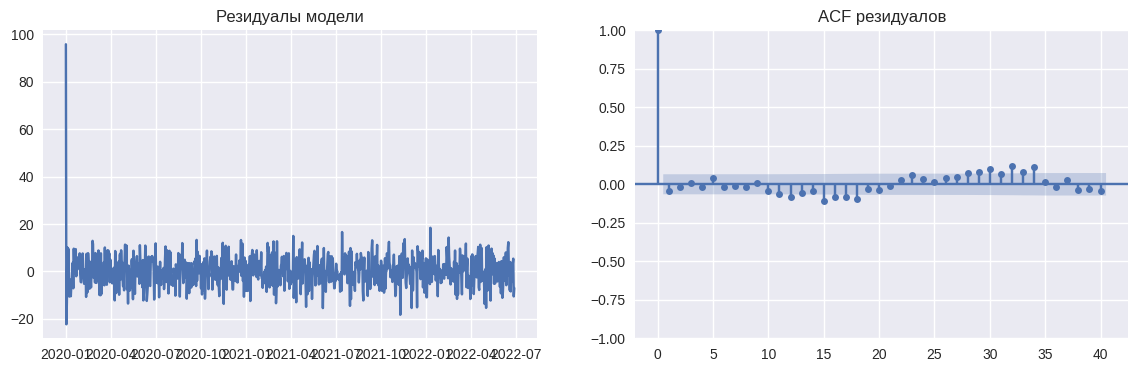

,lb_stat,lb_pvalue
10,6.535574,0.768441
20,56.218327,0.000027


In [ ]:
resid = best_model.resid.dropna()

fig, ax = plt.subplots(1,2, figsize=(14,4))
ax[0].plot(resid)
ax[0].set_title("Резидуалы модели")

plot_acf(resid, lags=40, ax=ax[1])
ax[1].set_title("ACF резидуалов")

plt.show()

acorr_ljungbox(resid, lags=[10,20], return_df=True)
